In [1]:
import tensorflow as tf
import matplotlib.image as mpimg
import numpy as np
import os
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.transform import resize, rotate, rescale
from skimage.filters import gaussian
from cv2 import addWeighted
from math import ceil, floor
from skimage.io import imsave
import warnings
from tqdm import tqdm

In [2]:


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

IMAGE_SIZE = 128

MAIN_PATH = '../augment/'

IMAGE_PATH = 'image/'
MASK_PATH = 'mask/'

IMPORT_PATH = 'before/'
EXPORT_PATH = 'after/'

'''
MAIN_PATH = '../augment_LIP/'

IMAGE_PATH = 'image/'
MASK_PATH = 'mask/'

IMPORT_PATH = 'before/'
EXPORT_PATH = 'after/'
'''

img_ids = next(os.walk(MAIN_PATH + IMPORT_PATH + IMAGE_PATH))[2]
IMG_CHANNELS = 3

def tf_resize_images(img_file_paths):
    img_data = []
    mask_data = []
    Y_train = np.zeros((len(img_file_paths), IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.bool)
    for index, file_path in tqdm(enumerate(img_file_paths), total=len(img_file_paths)):
        img = mpimg.imread(MAIN_PATH + IMPORT_PATH + IMAGE_PATH + file_path)[:, :, :3] 
        mask_ = imread(MAIN_PATH + IMPORT_PATH + MASK_PATH + file_path[:-4]+ '.png')
        #img = np.flip(img, 1)
        img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='constant', preserve_range=True)
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.bool)
        mask_ = np.expand_dims(resize(mask_, (IMAGE_SIZE, IMAGE_SIZE), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        mask = np.where(mask<0.0001, 0, 1)
        Y_train[index]=mask
        
        img_data.append(img)
        mask_data.append(np.squeeze(Y_train[index]))
    img_data = np.array(img_data, dtype=np.uint8)
    mask_data = np.array(mask_data, dtype=np.uint8)
    return img_data, mask_data

def central_scale_images(imgs, scales):
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    if imgs[0].shape[-1]==3:
        X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
        print('img',imgs[0].shape)

    elif imgs[0].shape[-1]==128:
        X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE,1))
        print('mask',imgs[0].shape)

    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img_data in tqdm(imgs,total=len(imgs)):
            if img_data.shape[-1]==128:
                img_data=tf.reshape(img_data,[1,128,128,1])
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    X_scale_data = np.array(X_scale_data, dtype=np.uint8)
    return X_scale_data

def central_scale_images2(imgs):
    scaled_data = []

    for img in tqdm(imgs,total=len(imgs)):
        scaled = rescale(img, scale=2.0, mode='constant')
        scaled_data.append(scaled[64:192,64:192])
    scaled_data = np.array(scaled_data, dtype=np.uint8)
    return scaled_data

def flip_images(X_imgs, horizontal, vertical):
    X_flip_data = []
    for img in tqdm(X_imgs, total=len(X_imgs)):
        if horizontal:
            horizontal_flip = np.fliplr(img)
            X_flip_data.append(horizontal_flip)
        if vertical:
            vertical_flip = np.flipud(img)
            X_flip_data.append(vertical_flip)
    X_flip_data = np.array(X_flip_data, dtype=np.uint8)
    return X_flip_data

def rotate_90_deg_images(X_imgs, rotate_90, rotate_180, rotate_270):
    X_rotate_data = []
    for img in X_imgs:
        if rotate_90:
            rotated = np.rot90(img)
            X_rotate_data.append(rotated)
        if rotate_180:
            rotated = np.rot90(img,1)
            X_rotate_data.append(rotated)
        if rotate_270:
            rotated = np.rot90(img,2)
            X_rotate_data.append(rotated)
    X_rotate_data = np.array(X_rotate_data, dtype=np.uint8)
    return X_rotate_data

def gaussian_noise(X_imgs, noise_strength=0.25):
    X_blurred_data = []
    for img in X_imgs:
        gaussian = np.random.random((128, 128, 1)).astype(np.uint8)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = addWeighted(img, 1-noise_strength, gaussian, noise_strength, -1)
        #blur = cv2.GaussianBlur(img,(15,15),0)
        X_blurred_data.append(gaussian_img)
    X_blurred_data = np.array(X_blurred_data, dtype=np.uint8)
    return X_blurred_data
    
def salt_and_pepper(X_imgs, percentage):
    X_salted_peppered_data = []
    amount = percentage/100 
    num_salt = np.ceil(amount * 128*128 * 0.2)
    num_pepper = np.ceil(amount * 128*128 * 0.8)
    X_imgs_copy = X_imgs.copy()
    
    for idx, img in enumerate(X_imgs_copy):
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
        img[coords[0], coords[1], :] = 0
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
        img[coords[0], coords[1], :] = 255
        X_salted_peppered_data.append(img)
        
    X_salted_peppered_data = np.array(X_salted_peppered_data, dtype=np.uint8)
    return X_salted_peppered_data

def rotate_images(X_imgs, deg_array, mode_reflect=False):
    X_rotated_data = []
    selected_mode = 'constant'
    if mode_reflect:
        selected_mode = 'reflect'
    for img in X_imgs:
        for val in deg_array: 
            rotated = rotate(img, val, preserve_range=True, mode=selected_mode)
            X_rotated_data.append(rotated)
    X_rotated_data=np.array(X_rotated_data, dtype=np.uint8)
    return X_rotated_data

def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr

In [3]:
imgs, masks = tf_resize_images(img_ids[:300])
imgs, masks = imgs[:300], masks[:300] 
output_img = []
output_mask = []
output_img.extend(imgs)
output_mask.extend(masks)
#output_img.extend(central_scale_images(imgs, [0.90, 0.75, 0.60]))

#output_img.extend(central_scale_images2(imgs))
#output_mask.extend(central_scale_images2(masks))

#output_mask.extend(central_scale_images(masks, [0.90, 0.75, 0.60]))
output_img.extend(flip_images(imgs,True,True))
output_mask.extend(flip_images(masks,True,True))
output_img.extend(rotate_90_deg_images(imgs,True,True,True))
output_mask.extend(rotate_90_deg_images(masks,True,True,True))
output_img.extend(gaussian_noise(imgs, 0.5))
output_mask.extend(masks)
output_img.extend(salt_and_pepper(imgs, 10))
output_mask.extend(masks)
output_img.extend(rotate_images(imgs, [45,135,225,315],True))
output_mask.extend(rotate_images(masks, [45,135,225,315],True))
#output_img.extend(translate_images(imgs))
#output_mask.extend(translate_images(masks))
output_img = np.array(output_img,dtype=np.uint8)
output_mask = np.array(output_mask,dtype=np.uint8)


100%|██████████| 300/300 [00:00<00:00, 268406.83it/s]


In [4]:
i=0
for idx, img in tqdm(enumerate(output_img), total=len(output_img)):
    imsave(MAIN_PATH+EXPORT_PATH+IMAGE_PATH+str(i)+'.jpg',img,)
    imsave(MAIN_PATH+EXPORT_PATH+MASK_PATH+str(i)+'.png',output_mask[idx])
    i=i+1
print('number of final instances: ',i)
print('multiplier: ',i/len(imgs))

100%|██████████| 3600/3600 [00:05<00:00, 616.60it/s]

number of final instances:  3600
multiplier:  12.0


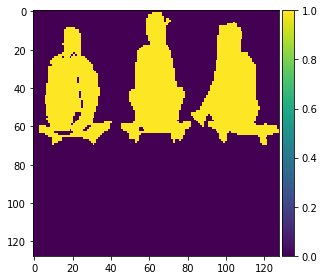

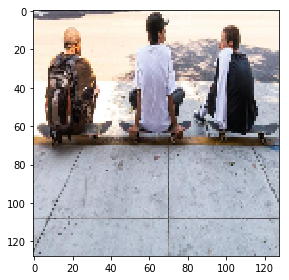

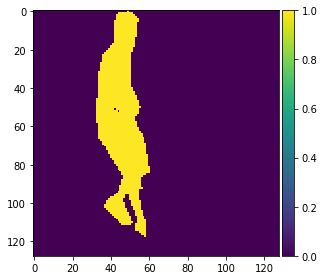

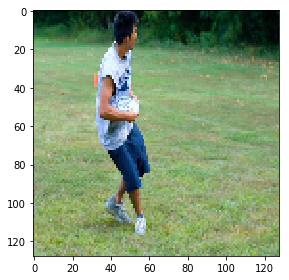

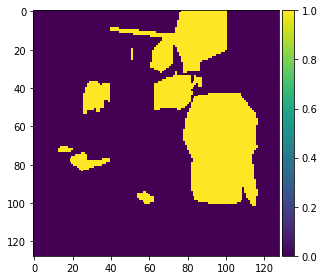

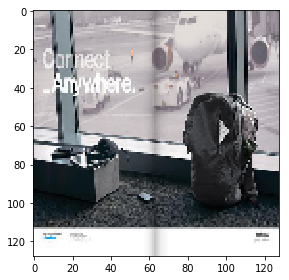

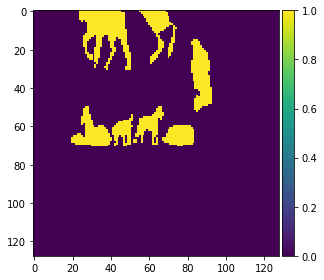

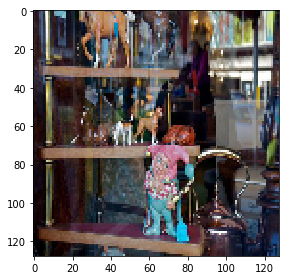

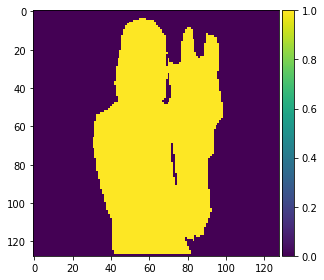

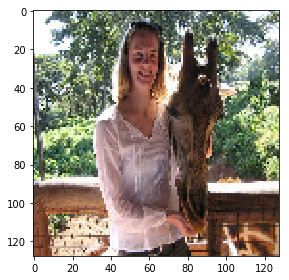

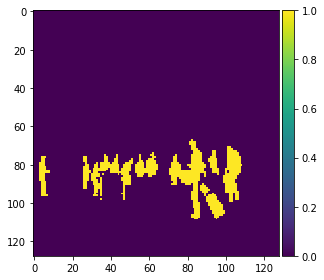

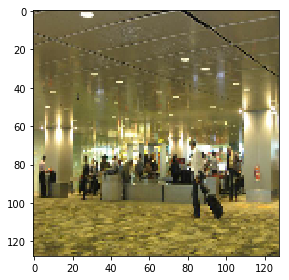

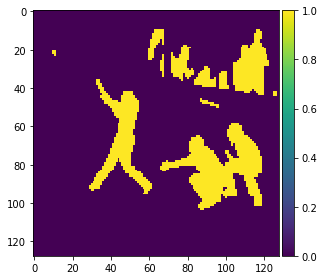

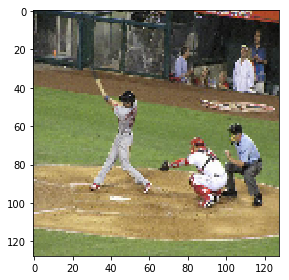

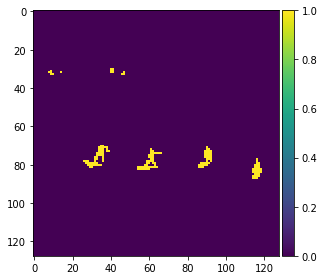

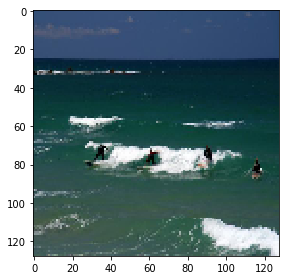

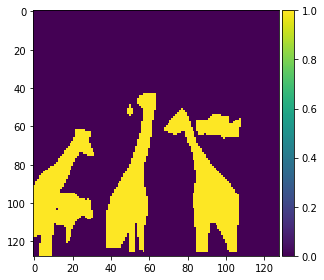

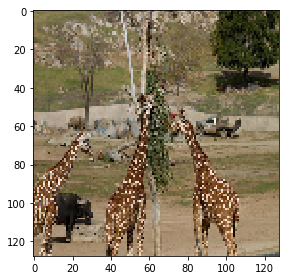

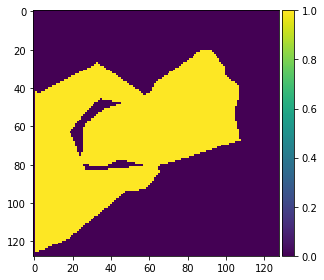

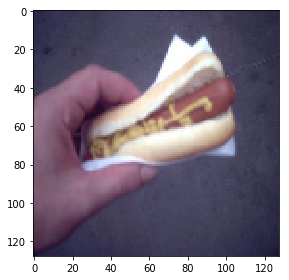

In [5]:
i=0
for img in masks:
    if i<10:
                    
        imshow(img)
        plt.show()
        imshow(imgs[i])
        plt.show()
    i+=1